In [1]:
from tqdm.notebook import tqdm
import webbrowser
from bs4 import NavigableString
import itertools
from pathlib import Path
from pprint import pp
import requests
import time
import wget
from bs4 import BeautifulSoup
import pandas as pd
from transformers import pipeline, AutoTokenizer
from tqdm.notebook import tnrange
from transformers import AutoTokenizer
import numpy as np
import ast

classifier = pipeline('sentiment-analysis')
ner = pipeline("ner")
summarize = pipeline("summarization")
text_classification_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
token_classification_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english")
summarization_tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-12-6")
s = requests.Session()

with Path("secrets.txt").open() as f:
    api_key = f.readline()


In [244]:
base_url = "https://api.regulations.gov/v4/documents"
params = {
    "filter[agencyId]": "CMS",
    "api_key": api_key,
    "page[number]": 1,
    "page[size]": 250,
    "filter[searchTerm]": "Changes to the Hospital Inpatient Prospective Payment System and Calendar 2019",
}

response = s.get(base_url, params=params)
response

<Response [200]>

In [ ]:
Q

In [248]:
for document in response.json()["data"]:
    if "Medicare Program: Hospital Inpatient Prospective Payment Systems for Acute Care Hospitals and Long Term Care Hospital Prospective Payment System and Proposed Policy Changes and Fiscal Year 2018 Rates; etc." in document["attributes"]["title"]:
        print("\n")
        pp(document)




{'id': 'CMS-2017-0055-0003',
 'type': 'documents',
 'attributes': {'documentType': 'Proposed Rule',
                'lastModifiedDate': '2017-06-17T01:02:30Z',
                'highlightedContent': '<mark><em>Inpatient</em></mark> '
                                      '<mark><em>Prospective</em></mark> '
                                      '<mark><em>Payment</em></mark> '
                                      '<mark><em>Systems</em></mark> \n'
                                      'for Acute Care '
                                      '<mark><em>Hospitals</em></mark> and the '
                                      'Long-Term Care '
                                      '<mark><em>Hospital</em></mark> '
                                      '<mark><em>Prospective</em></mark>&hellip;&nbsp;<mark><em>hospital</em></mark>] '
                                      '<mark><em>inpatient</em></mark> '
                                      '<mark><em>prospective</em></mark> '
             

In [249]:
responses = []
base_url = "https://api.regulations.gov/v4/comments"
params = {
    "filter[agencyId]": "CMS",
    "api_key": api_key,
    "page[number]": 1,
    "page[size]": 250,
    "sort": "lastModifiedDate",
    "filter[commentOnId]": "0900006482581b4b"
}
response = s.get(base_url, params=params)
while response.json()["meta"]['hasNextPage']==True:
    responses.append(response.json())
    params["page[number]"] += 1
    response = s.get(base_url,params=params)
links = []
for response in responses:
    for data in response["data"]:
        links.append(data["links"]["self"])

In [250]:
comments = []
for link in tqdm(links):
    comment = s.get(link, params={"api_key": api_key, "include": "attachments"}).json()
    comments.append(comment)

  0%|          | 0/4250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [258]:
# For parsing new comments
attachment_details = {}
for comment in tqdm(comments):
    key = comment["data"]["id"]
    comment = comment["data"]["attributes"]["comment"]
    attachment_details[key] = {"body":comment}


  0%|          | 0/551 [00:00<?, ?it/s]

In [255]:
# For manually parsing old comments
attachment_details = {}
i = 0
for comment in tqdm(comments):
    # print(comment)
    comment = comment["data"]["attributes"]["comment"]
    pp(comment)
    flag = False
    file_formats = comment["included"][0]["attributes"]["fileFormats"]
    key = comment["data"]["id"]
    for files in file_formats:
        # webbrowser.open(files["fileUrl"])
        if files['format']=="htm":
            r = s.get(files["fileUrl"])
            if r.status_code == 200:
                soup = BeautifulSoup(r.text, "lxml")
                for font in soup.find_all('font'):
                    if len(font.contents) > 0:
                        if type(font.contents[0]) != NavigableString:
                            if font.contents[0].contents[0]=="GENERAL":
                                flag = "body"
                                continue
                            if font.contents[0].contents[0]=="Category : ":
                                flag = "category"
                                continue
                    try:
                        if flag=="body" and font.contents:
                            attachment_details[key]["body"] += font.contents[0]
                        if flag=="category" and font.contents:
                            attachment_details[key] = {"category": font.contents[0].contents[0], "body": ""}
                            flag=False
                    except TypeError:
                        print(font)
                        attachment_details[key]["body"] = np.nan
                        attachment_details[key]["category"] = np.nan
                        continue
            else:
                print(r.status_code)


  0%|          | 0/551 [00:00<?, ?it/s]

('From a state perspective and having to build our SLR for the changes when '
 'finalized, the following questions arose:<br/><br/>1) When states do not '
 'have MA only EHs who are eligible to participate in the Medicaid EHR '
 'Incentive Program due to current program rules, should the states continue '
 'to build their SLR for related items generated in CMS final rules?  <br/>2) '
 'The proposed rule indicates alignment of EP CQMs with MIPS.  The proposed '
 'rule specifies when an EP electronically submits CQMs, they will only be '
 'required to submit &quot;6 self-selected&quot; CQMs.  For those EPs who '
 'utilize attestation rather than electronic submission of CQMs, how many are '
 'they required to submit?  Should they continue with 9 as current final rules '
 'indicate, or should the number be lowered to 6?<br/>3) For EHs, the rule is '
 'proposing &quot;2 self-selected quarters&quot; yet the rule does not '
 'indicate if these quarters would have to be consecutive.  For thos

TypeError: string indices must be integers

In [259]:
df = pd.DataFrame(attachment_details).T.reset_index()
df

,index,body
0,CMS-2017-0055-0004,From a state perspective and having to build o...
1,CMS-2017-0055-0005,Comment on the Proposed Rule (File Code CMS-16...
2,CMS-2017-0055-0006,as a consultant who helps providers with state...
3,CMS-2017-0055-0007,The proposed rule indicates that the domain re...
4,CMS-2017-0055-0008,To Whom It May Concern:<br/><br/>I am writing ...
...,...,...
546,CMS-2017-0055-0548,Thank you for the opportunity to provide comme...
547,CMS-2017-0055-0552,Thank you for the opportunity to provide comme...
548,CMS-2017-0055-0551,Thank you for the opportunity to provide comme...
549,CMS-2017-0055-0556,Thank you for the opportunity to provide comme...


In [262]:
df["body"].unique()

206

In [ ]:
def find_org(comment):
    out = ner(comment)
    if not out:
        return None
    ner_output = pd.DataFrame(out)
    df = ner_output[ner_output["entity"]=='I-ORG']
    reindexed = df.set_index(["index"]).reindex(range(max(ner_output["index"])+1))
    switch = False
    org = ""
    org_list = []
    for word in reindexed["word"]:
        if not pd.isnull(word):
            org+=word
            continue
        else:
            org_list.append(org)
            org = ""
    org_list = filter(None, org_list)
    org_list = [org.replace("#", "") for org in org_list]
    return org_list

In [267]:
comment_ml = []
for comment in tqdm(df["body"]):
    try:
        if len(summarization_tokenizer.encode(comment, max_length=500, truncation=True)) > 50:
            classifier_input = text_classification_tokenizer.decode(text_classification_tokenizer.encode(comment, max_length=500, truncation=True), skip_special_tokens=True)
            ner_input = token_classification_tokenizer.decode(token_classification_tokenizer.encode(comment, max_length=500, truncation=True), skip_special_tokens=True)
            summary_input = summarization_tokenizer.decode(summarization_tokenizer.encode(comment, max_length=500, truncation=True), skip_special_tokens=True)
            sentiment = classifier(classifier_input)
            summary = summarize(summary_input)
            comment_ml.append({"score": sentiment[0]["score"], "label": sentiment[0]["label"], "organization": find_org(ner_input), "summary": summary})
    except TypeError:
        comment_ml.append({"score": np.nan, "label": np.nan, "organization": np.nan})

  0%|          | 0/551 [00:00<?, ?it/s]

Your max_length is set to 142, but you input_length is only 90. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 66. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 54. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 119. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 103. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)
Your max_length is set to 142, but you input_length is only 76. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=50)


KeyboardInterrupt: 

In [268]:
comment_ml

ning the organs separate from the hospital bundled payment . I ask that you do the same for bone marrow and cord blood transplants .'}]},
 {'score': 0.7622485160827637,
  'label': 'NEGATIVE',
  'organization': [],
  'summary': [{'summary_text': ' Older patients in need may have difficulty obtaining a bone marrow or cord blood transplant if they are in the Medicare program . CMS addressed a similar problem in the context of solid organs and decided to pay the cost of obtaining the organs separate from the hospital bundled payment . I ask that you do the same for bone marrow and cord blood transplants .'}]},
 {'score': 0.9873781800270081,
  'label': 'NEGATIVE',
  'organization': [],
  'summary': [{'summary_text': ' I would like to comment on the Fiscal Year 2018 Hospital Inpatient Prospective Payment System Proposed Rule . I am a volunteer courier for bone marrow, going to one clinic to pick up cells and delivering them to another . I understand that Medicare does not reimburse for costs

In [269]:
df = pd.concat([df, pd.DataFrame(comment_ml)], axis=1)

In [271]:
df["score"].describe()

count    57.000000
mean      0.864403
std       0.126083
min       0.614679
25%       0.762249
50%       0.807489
75%       0.993803
max       0.999373
Name: score, dtype: float64

In [283]:
df_compare = pd.read_csv("CMS-2010-0020-0001_analysis.csv")

In [284]:
df_compare = df_compare.drop(index=140)

In [285]:
df_compare["score"].astype(float).describe()

count    246.000000
mean       0.944853
std        0.088685
min        0.590374
25%        0.986695
50%        0.986695
75%        0.986695
max        0.999607
Name: score, dtype: float64

## CSV connection

In [2]:
policy_comments = pd.read_csv("/home/collin/apps/medical_data_exploration/CMS-2010-0020-0001_analysis.csv")

In [3]:
policy_comments

,Unnamed: 0,index,category,body,score,label,organization,summary
0,0.0,CMS-2010-0020-0002,Ambulatory Surgical Center,I am writing to encourage you to halt any cuts...,0.9987537264823914,NEGATIVE,['ASC'],"[{'summary_text': "" I am writing to encourage ..."
1,1.0,CMS-2010-0020-0003,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
2,2.0,CMS-2010-0020-0004,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
3,3.0,CMS-2010-0020-0005,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
4,4.0,CMS-2010-0020-0006,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
...,...,...,...,...,...,...,...,...
246,245.0,CMS-2010-0020-0247,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...
247,246.0,CMS-2010-0020-0248,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...
248,247.0,CMS-2010-0020-0249,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...
249,248.0,CMS-2010-0020-0250,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...


In [4]:
policy_comments = policy_comments.drop(140)

In [5]:
def fix_summaries(x):
    try:
        if x is not np.nan:
            return ast.literal_eval(x)[0]["summary_text"]
        else:
            return ""
    except TypeError:
        print(x)
        return ""

In [6]:
policy_comments = policy_comments.dropna(axis=0, subset=["score"])

In [7]:
policy_comments

,Unnamed: 0,index,category,body,score,label,organization,summary
0,0.0,CMS-2010-0020-0002,Ambulatory Surgical Center,I am writing to encourage you to halt any cuts...,0.9987537264823914,NEGATIVE,['ASC'],"[{'summary_text': "" I am writing to encourage ..."
1,1.0,CMS-2010-0020-0003,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
2,2.0,CMS-2010-0020-0004,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
3,3.0,CMS-2010-0020-0005,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
4,4.0,CMS-2010-0020-0006,Individual,I am a patient who relies on interventional pa...,0.9866949319839478,NEGATIVE,"['Congress', 'ASC', 'Congress', 'Government']",[{'summary_text': ' A patient who relies on in...
...,...,...,...,...,...,...,...,...
246,245.0,CMS-2010-0020-0247,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...
247,246.0,CMS-2010-0020-0248,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...
248,247.0,CMS-2010-0020-0249,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...
249,248.0,CMS-2010-0020-0250,Health Care Provider/Association,NaN,0.7481210827827454,POSITIVE,NaN,[{'summary_text': ' CNN.com will feature iRepo...


In [8]:
policy_comments["summary"] = policy_comments["summary"].apply(fix_summaries)

In [9]:
policy_comments.reset_index()['summary'].str.lower().str.contains("radiology").sort_values(ascending=True)

0      False
155    False
156    False
157    False
158    False
       ...  
87     False
75     False
245    False
110     True
210     True
Name: summary, Length: 246, dtype: bool

In [10]:
policy_comments["score"] = policy_comments["score"].apply(float)

In [12]:
# TODO
policy_comments.where(policy_comments['label'] == "POSITIVE", other)[]


SyntaxError: invalid syntax (<ipython-input-12-a2ee966d611b>, line 1)

<ipython-input-11-69a18deab44c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax = policy_comments.reset_index()[policy_comments.reset_index()['summary'].str.lower().str.contains("cost").sort_values(ascending=True)].plot.scatter(x="index", y="score", c="r")


<AxesSubplot:xlabel='index', ylabel='score'>

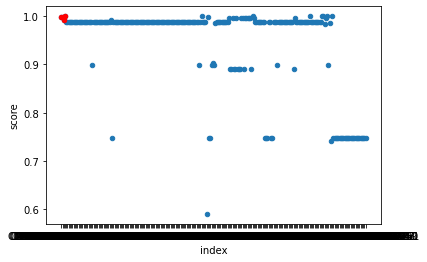

In [11]:
ax = policy_comments.reset_index()[policy_comments.reset_index()['summary'].str.lower().str.contains("cost").sort_values(ascending=True)].plot.scatter(x="index", y="score", c="r")
policy_comments.reset_index().plot.scatter(x="index", y="score", ax=ax, zorder=0)

In [11]:
csv_df = pd.read_csv("DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv")

In [12]:
icd9_codes = pd.read_csv("output.csv")

In [13]:
icd9_codes["icd9code"].loc[4592:5195] = icd9_codes["icd9code"].loc[4592:5195].apply(lambda x: np.int64(float(x)*100))
circulator_codes = list(icd9_codes["icd9code"].loc[4592:5195])

In [14]:
def convert_codes(x):
    try:
        return np.int64(x)
    except ValueError:
        pass

In [15]:
filtered_df = csv_df[csv_df.loc[:,"ICD9_DGNS_CD_1":"ICD9_DGNS_CD_10"].applymap(convert_codes).isin(circulator_codes).any(axis=1)]

In [16]:
filtered_df

,DESYNPUF_ID,CLM_ID,SEGMENT,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,...,HCPCS_CD_36,HCPCS_CD_37,HCPCS_CD_38,HCPCS_CD_39,HCPCS_CD_40,HCPCS_CD_41,HCPCS_CD_42,HCPCS_CD_43,HCPCS_CD_44,HCPCS_CD_45
5,00052705243EA128,196991176971757,1,20080912.0,20080912.0,1401HG,14000.0,0.0,6.132011e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0007F12A492FD25D,196661176963773,1,20080919.0,20080922.0,3400WD,5000.0,0.0,8.956736e+09,6.551008e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,000B97BA2314E971,196231176958277,1,20091209.0,20091213.0,2200GD,2000.0,0.0,3.115083e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,000C7486B11E7030,196641176984178,1,20081015.0,20081021.0,4400MM,30000.0,0.0,5.520895e+09,6.142535e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,0011714C14B52EEB,196511177006504,1,20090826.0,20090829.0,3800YA,3000.0,0.0,4.256485e+09,4.317374e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66765,FFF46A3796CB82BB,196511176973115,1,20080306.0,20080313.0,1100SK,6000.0,0.0,1.656662e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66766,FFF5F9218AB04A41,196321176987073,1,20081018.0,20081021.0,3303NG,5000.0,0.0,6.083155e+09,9.112796e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66767,FFF5F9218AB04A41,196381176989400,1,20091103.0,20091106.0,33026U,4000.0,0.0,2.584638e+09,4.410779e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66768,FFF8B49458F9FFA7,196641177004609,1,20080329.0,20080331.0,0100UV,3000.0,0.0,2.509032e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
filtered_df["CLM_PMT_AMT"].describe()

count    39568.000000
mean     10032.210372
std       9738.276671
min      -3000.000000
25%       4000.000000
50%       7000.000000
75%      12000.000000
max      57000.000000
Name: CLM_PMT_AMT, dtype: float64

In [18]:
base_url = "https://api.regulations.gov/v4/documents/CMS-2010-0020-0001"
params = {
    "api_key": api_key,
    "include": "attachments"
}
response = s.get(base_url, params=params)

In [19]:
response.json()["data"]["attributes"]["fileFormats"][0]["fileUrl"]

'https://downloads.regulations.gov/CMS-2010-0020-0001/content.pdf'